## 加载库文件

In [1]:
import math

import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

from sparrow.models.ssdlite import SSDLite
from sparrow.models.movenet import MoveNet
from sparrow_cli import load_model_pt

## Configuration

### For SSDLite

In [2]:
# Input size used for both models. If you trained with another size, change here.
DET_INPUT = 320           # SSDLite inference size (square)

# Anchor / strides must match your training config
STRIDES = (8, 16, 32)
RATIOS  = (1.0, 2.0, 0.5)
SCALES  = (1.0, 1.26)     # 2 scales per level -> A=6 anchors/loc

# # Score and NMS thresholds for detection
# CONF_THR = 0.4
# NMS_IOU  = 0.5
# MAX_DETS = 100

# 阈值先放松一点，确认能出框再调回去
CONF_THR = 0.2
NMS_IOU  = 0.5
MAX_DETS = 100

# COCO class mapping. We assume "background + 80 classes", bg=0, person=1
COCO_PERSON_CLASS = 1
NUM_CLASSES = 81

### For MoveNet

In [3]:
# Input size used for both models. If you trained with another size, change here.
POSE_INPUT = 192          # MoveNet inference size (square)

# For MoveNet decode (heatmap stride relative to input)
POSE_STRIDE = 4  # 192/48 = 8 if output is 48x48 as in comments
NUM_JOINTS = 17

SKELETON = [
    (5, 7), (7, 9), (6, 8), (8, 10),            # arms
    (11, 13), (13, 15), (12, 14), (14, 16),     # legs
    (5, 6), (11, 12),                           # shoulders, hips
    (0, 1), (1, 2), (2, 3), (3, 4),             # head
    (5, 11), (6, 12)                            # torso
]

## Utilities

### 1) `letterbox(...)`

* **做什么**：把任意尺寸的图像按比例缩放到不超过 `new_size X new_size`，并在周围用常数值（这里是 114 的灰色）**填充成正方形**。这能在不拉伸图像的前提下，适配固定输入大小的模型。
* **返回**：

  * `canvas`：填充后的正方形图（大小 `new_size X new_size`）。
  * `scale`：原图→填充图的缩放比例（同一比例用于宽和高）。
  * `left, top`：在正方形里，缩放后图像的左上角偏移（像素）。
* **为什么要它**：很多检测/姿态模型要求固定输入大小。保持**纵横比**不变能避免几何畸变，便于后续把预测框/关键点再映射回原图。

In [4]:
def letterbox(im, new_size=DET_INPUT, stride=32):
    h, w = im.shape[:2]
    scale = min(new_size / h, new_size / w)
    nh, nw = int(round(h * scale)), int(round(w * scale))
    im_resized = cv2.resize(im, (nw, nh), interpolation=cv2.INTER_LINEAR)
    canvas = np.full((new_size, new_size, 3), 114, dtype=np.uint8)
    top = (new_size - nh) // 2
    left = (new_size - nw) // 2
    canvas[top:top+nh, left:left+nw] = im_resized
    return canvas, scale, left, top

### 2) `inv_letterbox_xyxy(xyxy, scale, left, top)`

* **做什么**：把在**letterbox 后坐标系**里的框（`[x1,y1,x2,y2]`）**还原到原图坐标**。
* **原理**：先减去 padding 的偏移 `left, top`，再除以缩放比例 `scale`。
* **使用场景**：模型输出或后处理（NMS）通常在 letterbox 空间完成，最后可视化/评估时要把框映射回原图。

In [5]:
def inv_letterbox_xyxy(xyxy, scale, left, top):
    x1, y1, x2, y2 = xyxy
    return np.array([(x1 - left)/scale, (y1 - top)/scale, (x2 - left)/scale, (y2 - top)/scale], dtype=np.float32)

### 3) `inv_letterbox_points(points, scale, left, top)`

* **做什么**：把一组关键点（`[..., 2]` 里是 `x,y`，可能还有置信度）从 letterbox 空间**还原到原图**。
* **原理与上面一致**：对每个点做 `(x - left)/scale` 与 `(y - top)/scale`。

> 小结：`letterbox` 负责“进”模型，`inv_letterbox_*` 负责把预测“出”回原图，一进一出配套使用，坐标就不会飘。

In [6]:
def inv_letterbox_points(points, scale, left, top):
    pts = points.copy()
    pts[..., 0] = (pts[..., 0] - left) / scale
    pts[..., 1] = (pts[..., 1] - top) / scale
    return pts

### 4) `iou_xyxy(a, b)`

* **做什么**：计算两组矩形框 `a` 和 `b`（均为 `xyxy` 格式）的两两 **IoU（交并比）**，返回形状 `[N, M]` 的矩阵。
* **流程**：

  * 交集矩形的左上角取坐标最大值、右下角取最小值；
  * 交集面积 = 交集宽×高（小于 0 的裁成 0）；
  * 并集面积 = 面积(a) + 面积(b) − 交集面积；
  * IoU = 交集 / 并集（加 `1e-6` 防止除零）。
* **用途**：NMS、评估 mAP、匹配框等。

In [7]:
def iou_xyxy(a, b):
    # a: [N,4], b: [M,4]
    inter_x1 = np.maximum(a[:, None, 0], b[None, :, 0])
    inter_y1 = np.maximum(a[:, None, 1], b[None, :, 1])
    inter_x2 = np.minimum(a[:, None, 2], b[None, :, 2])
    inter_y2 = np.minimum(a[:, None, 3], b[None, :, 3])
    inter_w = np.clip(inter_x2 - inter_x1, 0, None)
    inter_h = np.clip(inter_y2 - inter_y1, 0, None)
    inter = inter_w * inter_h
    area_a = (a[:, 2] - a[:, 0]) * (a[:, 3] - a[:, 1])
    area_b = (b[:, 2] - b[:, 0]) * (b[:, 3] - b[:, 1])
    union = area_a[:, None] + area_b[None, :] - inter
    return inter / (union + 1e-6)

### 5) `nms(boxes, scores, iou_thr=0.5, max_dets=300)`

* **做什么**：**非极大值抑制（NMS）**。在一堆候选框中，保留分数高且与已保留框 **IoU < 阈值** 的框，去掉高度重叠的冗余框。
* **流程**：

  1. 按 `scores` 从高到低排序；
  2. 取当前分最高的框 `i` 放入 `keep`；
  3. 计算其与剩余所有框的 IoU，**删除** IoU ≥ `iou_thr` 的那些；
  4. 循环直到空或达到 `max_dets`。
* **返回**：保留下来的索引数组（`int64`）。
* **复杂度**：朴素实现大约 $O(K^2)$（K 为候选框数），但对常见检测数量足够快。

In [8]:
def nms(boxes, scores, iou_thr=0.5, max_dets=300):
    idx = scores.argsort()[::-1]
    keep = []
    while idx.size > 0 and len(keep) < max_dets:
        i = idx[0]
        keep.append(i)
        if idx.size == 1: break
        ious = iou_xyxy(boxes[i:i+1], boxes[idx[1:]])[0]
        idx = idx[1:][ious < iou_thr]
    return np.array(keep, dtype=np.int64)


### 常见坑与小建议

* `letterbox` 的 `scale/left/top` 一定要**成对保存**，否则无法准确反变换；检测框与关键点都要用对应的 `inv_letterbox_*`。
* `xyxy` 坐标格式默认 **不含**闭区间+1 的处理，面积用 `width = x2-x1`、`height = y2-y1`；确保与你数据的定义一致。
* `nms` 的 `iou_thr`：行人/密集目标可适当调低（如 0.45），避免误删；`max_dets` 可防止尾部长队影响速度。
* 若模型输出本来就在**原图坐标**（少见），就不要再用 `inv_letterbox_*`，否则会错位。

## Anchors & Decoder for SSDLite

### `make_anchors(feats_hw, strides, ratios, scales)`

**作用**：根据各层特征图尺寸，生成整张输入图（例如 384×384）坐标系下的**密集锚框（anchors, xyxy）**。

**输入**

* `feats_hw`: 形如 `[(H3,W3),(H4,W4),(H5,W5)]`，对应 P3/P4/P5 三个金字塔层的特征图高宽。
* `strides`: 每层步长（例如 `(8,16,32)`）。输入图上每个特征点对齐的像素间隔就是 stride。
* `ratios`, `scales`: 每个特征点要铺设的**长宽比**和**尺度**组合，决定每个点上有多少个 anchor（A = len(ratios)\*len(scales)）。

**过程**

1. 对每层：先用网格拿到每个单元格中心 `(cx, cy) = ((x+0.5)*stride, (y+0.5)*stride)`。
2. 对每个比例/尺度组合，计算锚框的宽高：

   * $w = \text{scale} \cdot \text{stride} \cdot \sqrt{\text{ratio}}$
   * $h = \text{scale} \cdot \text{stride} / \sqrt{\text{ratio}}$
3. 把每个中心配上每个 $(w,h)$，转成 `xyxy = [cx-w/2, cy-h/2, cx+w/2, cy+h/2]`。
4. 拼接三层，返回形如 `[sum(HW*A), 4]` 的 numpy 数组。

**输出**

* 全部锚框坐标（在**输入图坐标系**，不是特征图坐标）。

> 小结：**锚框是先验框**，回归头学的是“相对锚框”的偏移量。`make_anchors` 必须和你**训练时的 ratios/scales/strides 完全一致**。

In [9]:
def make_anchors(feats_hw, strides=STRIDES, ratios=RATIOS, scales=SCALES):
    # feats_hw: list of (H, W) for P3,P4,P5
    anchors = []
    for (H, W), s in zip(feats_hw, strides):
        ys, xs = np.meshgrid(np.arange(H), np.arange(W), indexing='ij')
        cx = (xs + 0.5) * s
        cy = (ys + 0.5) * s
        base = []
        for r in ratios:
            for sc in scales:
                w = sc * s * math.sqrt(r)
                h = sc * s / math.sqrt(r)
                base.append((w, h))
        base = np.array(base, dtype=np.float32)  # [A,2]
        A = base.shape[0]
        # expand per grid
        centers = np.stack([cx, cy], axis=-1).reshape(-1, 1, 2)
        wh = np.broadcast_to(base[None, ...], (H*W, A, 2))
        # convert to xyxy
        xyxy = np.concatenate([centers - wh/2, centers + wh/2], axis=-1)
        anchors.append(xyxy.reshape(-1, 4))
    return np.concatenate(anchors, axis=0)  # [sum(HW*A), 4]


### `decode_ssd(cls_list, reg_list, feats_hw, conf_thr)`

**作用**：把 SSDLite 的分类/回归输出解码成**实际检测框**，并**过滤出 person 类**、做 **NMS**。

**输入**

* `cls_list`: 每层的分类输出 list，形如 `[B, HW*A, C]`。这里默认 **有背景类**（C=81, 0=背景, 1=person）。
* `reg_list`: 每层的回归输出 list，形如 `[B, HW*A, 4]`，每个锚框对应 4 个回归量。
* `feats_hw`: 各层 `(H,W)`，用于重建 anchors。
* `conf_thr`: 分数阈值。

**过程**

1. 拼接各层：`cls = cat(..., dim=1)` 得到 `[B, N, C]`，`reg = cat(..., dim=1)` 得到 `[B, N, 4]`。
2. `softmax` 得到**类别概率**（因为假设有背景类，用 softmax）。抓出 `person` 类（索引 1）的概率。
3. 调 `make_anchors(feats_hw)` 得到 N 个 anchors（与 `cls/reg` 对齐）。
4. **回归解码**（SSD 经典公式，假设 variance = 0.1/0.2）：

   * 先把 anchor 转为中心宽高 $(x_a,y_a,w_a,h_a)$。
   * 回归量记为 $(t_x,t_y,t_w,t_h)$。
   * 解码：

     $$
     x = x_a + t_x \cdot v_x \cdot w_a,\quad
     y = y_a + t_y \cdot v_y \cdot h_a
     $$

     $$
     w = w_a \cdot e^{t_w \cdot v_w},\quad
     h = h_a \cdot e^{t_h \cdot v_h}
     $$

     （这里 $v_x=v_y=0.1,\ v_w=v_h=0.2$）
   * 再把 $(x,y,w,h)$ 还原为 `xyxy`。
5. 用 `conf_thr` 过滤 `person` 类得分，再对剩余框做 **NMS**（`iou_thr=NMS_IOU`，最多保留 `MAX_DETS`）。

**输出**

* `boxes`: 过滤+NMS 后的 `xyxy` 框（在**输入图坐标系**）。
* `scores`: 对应的 `person` 概率。

**关键假设与容易踩的点**

* **是否有背景类？** 这段代码用 `softmax` + `person=1`，意味着类别 0 是背景。如果你训练时用的是 **多标签 sigmoid（无背景）**，这里要改成 `sigmoid`，并调整类别索引与阈值逻辑。
* **variance 设置** 要和训练时一致；如果训练用的不是 (0.1,0.2)，解码会偏。
* `feats_hw/strides/ratios/scales` 必须与训练一致，否则锚框错位，解码框会飘。

In [10]:
def decode_ssd(
    cls_list, reg_list, feats_hw,
    conf_thr=CONF_THR,
    strides_override=None,
    cls_mode="auto",            # "softmax" | "sigmoid" | "auto"
    person_idx_softmax=1,       # softmax 时，COCO person=1（0=背景）
    person_idx_sigmoid=0        # sigmoid 时，若无背景，很多实现把 person 放到 0
):
    # concat
    cls = torch.cat(cls_list, dim=1)   # [B,N,C]
    reg = torch.cat(reg_list, dim=1)   # [B,N,4]
    B, N, C = cls.shape
    assert B == 1

    use_strides = strides_override if strides_override is not None else STRIDES
    anchors = make_anchors(feats_hw, strides=use_strides)  # [N,4]

    if anchors.shape[0] != N:
        raise ValueError(f"anchors({anchors.shape[0]}) != preds({N}); feats_hw={feats_hw}, strides={use_strides}")

    deltas = reg[0].cpu().numpy()  # [N,4]

    # SSD decode
    wa = anchors[:, 2] - anchors[:, 0]
    ha = anchors[:, 3] - anchors[:, 1]
    xa = anchors[:, 0] + 0.5 * wa
    ya = anchors[:, 1] + 0.5 * ha

    tx, ty, tw, th = deltas[:, 0], deltas[:, 1], deltas[:, 2], deltas[:, 3]
    vx, vy, vw, vh = 0.1, 0.1, 0.2, 0.2   # 若训练时不同，这里要改
    xc = xa + tx * vx * wa
    yc = ya + ty * vy * ha
    ww = wa * np.exp(tw * vw)
    hh = ha * np.exp(th * vh)
    x1 = xc - 0.5 * ww
    y1 = yc - 0.5 * hh
    x2 = xc + 0.5 * ww
    y2 = yc + 0.5 * hh
    xyxy = np.stack([x1, y1, x2, y2], axis=-1)

    # ---- 两种分类模式都算一遍，便于对比 ----
    logits = cls[0]  # [N,C]
    probs_softmax = torch.softmax(logits, dim=-1).cpu().numpy()
    probs_sigmoid = torch.sigmoid(logits).cpu().numpy()

    # 统计一下分布，帮你判断该走哪条路径
    ps = probs_softmax[:, person_idx_softmax] if person_idx_softmax < probs_softmax.shape[1] else None
    pg = probs_sigmoid[:, person_idx_sigmoid]
    print("[DEBUG] softmax(person@{}): min/max/mean = {}".format(
        person_idx_softmax,
        "NA" if ps is None else (float(ps.min()), float(ps.max()), float(ps.mean()))
    ))
    print("[DEBUG] sigmoid(person@{}): min/max/mean = {}".format(
        person_idx_sigmoid,
        (float(pg.min()), float(pg.max()), float(pg.mean()))
    ))

    # 选择模式：auto 时选“最高峰更像真的”那条（经验：max > 0.4 视为有希望）
    mode = cls_mode
    if cls_mode == "auto":
        m_soft = -1.0 if ps is None else float(ps.max())
        m_sig = float(pg.max())
        mode = "softmax" if m_soft > m_sig else "sigmoid"
        print(f"[DEBUG] auto choose = {mode} (softmax max={m_soft:.3f}, sigmoid max={m_sig:.3f})")

    if mode == "softmax":
        per_scores = probs_softmax[:, person_idx_softmax] if ps is not None else np.zeros((N,), np.float32)
    elif mode == "sigmoid":
        per_scores = probs_sigmoid[:, person_idx_sigmoid]
    else:
        raise ValueError("cls_mode must be 'auto'|'softmax'|'sigmoid'")

    # 阈值先放宽一些，避免一刀切没框
    th = min(conf_thr, 0.2)  # 保护性降阈，后面你再收紧
    mask = per_scores >= th
    boxes = xyxy[mask]
    scores = per_scores[mask]

    print(f"[DEBUG] before NMS: {mask.sum()} candidates (thr={th})")
    if boxes.shape[0] > 0:
        keep = nms(boxes, scores, iou_thr=NMS_IOU, max_dets=MAX_DETS)
        boxes = boxes[keep]
        scores = scores[keep]
    print(f"[DEBUG] after NMS: {boxes.shape[0]} boxes")
    return boxes, scores


## Decoder for Movenet

### `decode_movenet(outputs, input_size, stride)`

**作用**：把 MoveNet 头部输出（`heatmaps` + `offsets`）解码为 **17 个关键点的 (x,y,conf)**。

**输入**

* `outputs["heatmaps"]`: 形如 `[B, 17, H, W]`，每个关节点一张热力图。
* `outputs["offsets"]`: 形如 `[B, 34, H, W]`，每个关节点 2 个通道（x/y 偏移），共 34 通道。
* `stride`: 把热力图坐标放大回输入图坐标的比例（例如输入 384、heatmap 48，则 stride=8）。

**过程**（每个关节点 `j`）

1. 在 `heatmaps[j]` 上找最大值位置 `(y, x)`（最简单的 argmax 解码）。
2. 计算该点的**基础像素坐标**：`(px,py)=(x*stride, y*stride)`。
3. 从 `offsets` 拿到这个位置处该关节点的偏移 `(ox, oy)`：通道索引分别是 `2*j` 和 `2*j+1`。
4. 关键点坐标：`(kx,ky)=(px+ox, py+oy)`；同时把热力图峰值 `heat[y,x]` 作为该点的 `conf`。
5. 拼成 `[17,3]` 返回。

**输出**

* `kpts`: `[17, 3]` 数组，每行是 `(x, y, conf)`，坐标在**模型输入图坐标系**。

**说明与改进点**

* 这是**单点 argmax** 的基础解码，简单稳定。如果你想再细化，可用 **软 argmax**、**高斯拟合**、或在峰值周围做二次插值。
* 关键是 `stride` 要和实际 `heatmap` 尺寸匹配（`stride = input_size / H`，若非整除以实际网络下采样为准）。
* 有的实现还会用 `centers/regs` 辅助多人体解析，这里走的是 “先检测人框→裁剪→单人体姿态”的两阶段逻辑，所以只需要 `heatmaps+offsets` 即可。

In [11]:
def decode_movenet(outputs, input_size=POSE_INPUT, stride=POSE_STRIDE):
    # outputs: dict with keys "heatmaps" (B,17,H,W), "offsets" (B,34,H,W)
    hm = outputs["heatmaps"][0]         # [17,H,W]
    off = outputs["offsets"][0]         # [34,H,W] -> (ox,oy) per joint
    H, W = hm.shape[-2], hm.shape[-1]

    hm_np = hm.detach().cpu().numpy()
    off_np = off.detach().cpu().numpy()

    kpts = []
    for j in range(NUM_JOINTS):
        heat = hm_np[j]
        idx = np.argmax(heat)
        y, x = np.unravel_index(idx, heat.shape)
        # base coord on the heatmap grid
        px = x * stride
        py = y * stride
        ox = off_np[2*j, y, x]
        oy = off_np[2*j+1, y, x]
        kx = px + ox
        ky = py + oy
        conf = heat[y, x]
        kpts.append([kx, ky, conf])
    return np.array(kpts, dtype=np.float32)  # [17,3]

## Visualization

In [12]:
def draw_keypoints(img, kpts, color=(0, 255, 0)):
    for x, y, c in kpts:
        if c > 0.2:
            cv2.circle(img, (int(x), int(y)), 3, color, -1, lineType=cv2.LINE_AA)

    for a, b in SKELETON:
        xa, ya, ca = kpts[a]
        xb, yb, cb = kpts[b]
        if ca > 0.2 and cb > 0.2:
            cv2.line(img, (int(xa), int(ya)), (int(xb), int(yb)), color, 2, lineType=cv2.LINE_AA)

def crop_image(im, box, expand=0.1):
    h, w = im.shape[:2]
    x1, y1, x2, y2 = box
    bw = x2 - x1
    bh = y2 - y1
    x1 = max(0, int(x1 - expand * bw))
    y1 = max(0, int(y1 - expand * bh))
    x2 = min(w, int(x2 + expand * bw))
    y2 = min(h, int(y2 + expand * bh))
    return im[y1:y2, x1:x2].copy(), (x1, y1, x2, y2)

## Main Pipeline

In [13]:
def load_weights_strict(model, ckpt_path):
    sd = torch.load(ckpt_path, map_location='cpu')
    # 可能的封装层
    for k in ['state_dict', 'model', 'ema', 'ema_state_dict']:
        if isinstance(sd, dict) and k in sd and isinstance(sd[k], dict):
            sd = sd[k]
            break
    # 去掉可能的 'module.' 前缀
    new_sd = {}
    for k, v in sd.items():
        nk = k.replace('module.', '')
        new_sd[nk] = v

    missing, unexpected = model.load_state_dict(new_sd, strict=False)
    print('[load] missing keys:', missing)
    print('[load] unexpected keys:', unexpected)

    # 再对 head 做一下 sanity check：打印分类头最后一层权重的均值/方差
    head_keys = [k for k in model.state_dict().keys() if 'cls' in k or 'classification' in k]
    for k in head_keys:
        w = model.state_dict()[k]
        if w.dtype.is_floating_point:
            print(f'[head] {k}: mean={float(w.mean()):.5f}, std={float(w.std()):.5f}')

### 1) Load models

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
ssdlite_weights = "./outputs/ssdlite/best.pt"
movenet_weights = "./outputs/movenet/best.pt"

# Load the models
ssdlite = SSDLite(num_classes=NUM_CLASSES, backbone="mobilenet_v2", width_mult=1.0)
# movenet = MoveNet(backbone="shufflenet_v2", num_joints=NUM_JOINTS, width_mult=1.2)

# Load the parameters
load_model_pt(ssdlite, ssdlite_weights, strict=False); ssdlite.eval().to(device)
# load_model_pt(movenet, movenet_weights, strict=False); movenet.eval().to(device)

[INFO] <2025-09-24 16:27:19> [load_model_pt] - The weights file is loaded: ./outputs/ssdlite/best.pt (matched 426/426 keys)


SSDLite(
  (backbone): MobileNetV2Backbone(
    (stem): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (features): ModuleList(
      (0): Sequential(
        (0): InvertedResidual(
          (conv): Sequential(
            (0): Sequential(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU6(inplace=True)
            )
            (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
      )
      (1): Sequential(
        (0): InvertedResidual(
          (conv): Sequential(
            (0): Sequenti

### 2) Read image + letterbox for detection

In [15]:
# Load the image
image_path = "./india_road.png" 
im0 = cv2.imread(str(image_path))
if im0 is None:
    raise FileNotFoundError(f"Failed to read image: {image_path}")
det_in, scale, left, top = letterbox(im0, new_size=DET_INPUT)
rgb = cv2.cvtColor(det_in, cv2.COLOR_BGR2RGB)
det_in_t = torch.from_numpy(rgb.transpose(2, 0, 1).copy()).float() / 255.0
det_in_t = det_in_t.unsqueeze(0).to(device)

### 3) Forward SSDLite

Size of cls_list B: torch.Size([1, 38400, 81]), HW*A: torch.Size([1, 9600, 81]), C: torch.Size([1, 2400, 81])
Size of reg_list B: torch.Size([1, 38400, 4]), HW*A: torch.Size([1, 9600, 4]), C: torch.Size([1, 2400, 4])
feats_hw  = [(80, 80), (40, 40), (20, 20)]
strides   = [4, 8, 16]
[DEBUG] softmax(person@1): min/max/mean = (0.07145384699106216, 0.22171276807785034, 0.14931145310401917)
[DEBUG] sigmoid(person@0): min/max/mean = (0.7670178413391113, 0.8970925807952881, 0.7841699719429016)
[DEBUG] before NMS: 50400 candidates (thr=0.2)
[DEBUG] after NMS: 100 boxes

[DEBUG] decode_ssd output (letterbox coord):
 num boxes after conf-thr+NMS: 100
 score stats: min=0.859  max=0.897  mean=0.868
 top-10 boxes (xyxy @ letterbox) and scores:
  #00  [159.2,51.4,176.9,132.0]  score=0.897
  #01  [192.5,50.8,209.1,129.4]  score=0.892
  #02  [172.3,48.9,188.8,129.8]  score=0.892
  #03  [142.6,55.0,162.5,129.0]  score=0.890
  #04  [210.3,53.0,225.0,116.3]  score=0.888
  #05  [145.4,150.9,162.8,244.5]  

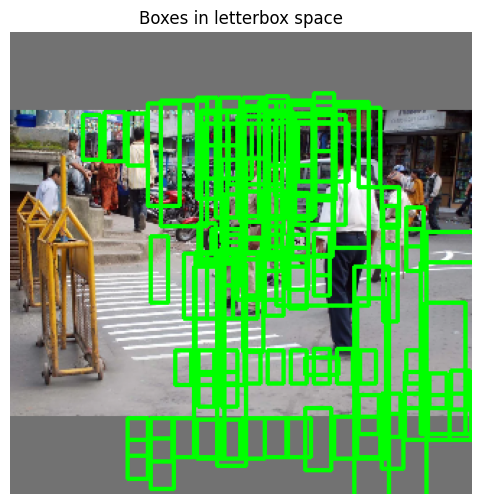

In [16]:
# Forward with SSDLite
with torch.no_grad():
    det_out = ssdlite(det_in_t)
cls_list = det_out["cls_logits"]  # list of [B, HW*A, C]
reg_list = det_out["bbox_regs"]   # list of [B, HW*A, 4]

print(f"Size of cls_list B: {cls_list[0].shape}, HW*A: {cls_list[1].shape}, C: {cls_list[2].shape}")
print(f"Size of reg_list B: {reg_list[0].shape}, HW*A: {reg_list[1].shape}, C: {reg_list[2].shape}")

# determine feature map sizes and strides dynamically
feats_hw = []
# strides_dyn = []
# feats_hw 已按 reg_list 恢复为 [(80,80),(40,40),(20,20)]
strides_dyn = [DET_INPUT // H for (H, W) in feats_hw]  # → [4,8,16] if DET_INPUT=320
A = len(RATIOS) * len(SCALES)

for reg in reg_list:
    B, NA, _ = reg.shape          # NA = H*W*A
    HW = NA // A
    H = int(round(math.sqrt(HW))) # assume square-ish
    W = HW // H
    feats_hw.append((H, W))
    # infer stride from input size (assume integer downsample)
    s = DET_INPUT // H
    strides_dyn.append(s)

print('feats_hw  =', feats_hw)        # expected: [(80,80),(40,40),(20,20)]
print('strides   =', strides_dyn)     # expected: [4, 8, 16]

PERSON_IDX=0

boxes_in_det, scores = decode_ssd(
    cls_list, reg_list, feats_hw,
    conf_thr=CONF_THR,
    strides_override=strides_dyn,   # 关键：用 [4,8,16]
    cls_mode="sigmoid",             # 关键：无背景 → sigmoid
    person_idx_softmax=1,           # 无效，但保留参数
    person_idx_sigmoid=PERSON_IDX   # = 0
)

# ---------- DEBUG: inspect detections before mapping back ----------
print("\n[DEBUG] decode_ssd output (letterbox coord):")
print(" num boxes after conf-thr+NMS:", len(boxes_in_det))

# 看看分数分布
if len(scores) > 0:
    print(" score stats: min={:.3f}  max={:.3f}  mean={:.3f}".format(
        float(scores.min()), float(scores.max()), float(scores.mean())
    ))
else:
    print(" score stats: empty")

# 打印前 10 个（按分数排序）
if len(scores) > 0:
    order = np.argsort(scores)[::-1]
    topk = order[:10]
    print(" top-10 boxes (xyxy @ letterbox) and scores:")
    for i, idx in enumerate(topk):
        b = boxes_in_det[idx]
        s = float(scores[idx])
        print(f"  #{i:02d}  [{b[0]:.1f},{b[1]:.1f},{b[2]:.1f},{b[3]:.1f}]  score={s:.3f}")

# 可视化：在 letterbox 图上先画一遍，确认是否为空
dbg = det_in.copy()
for i, b in enumerate(boxes_in_det.astype(int)):
    cv2.rectangle(dbg, (b[0], b[1]), (b[2], b[3]), (0,255,0), 2)
dbg_rgb = cv2.cvtColor(dbg, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6,6)); plt.imshow(dbg_rgb); plt.axis('off'); plt.title('Boxes in letterbox space'); plt.show()
# ---------------------------------------------------------------


# Map boxes back to original image coords
boxes = np.array([inv_letterbox_xyxy(b, scale, left, top) for b in boxes_in_det], dtype=np.float32)

vis = im0.copy()
for b in boxes.astype(int):
    cv2.rectangle(vis, (b[0], b[1]), (b[2], b[3]), (0, 200, 255), 2)

###  4) For each person, run MoveNet on a crop and draw keypoints back

In [17]:
# Forward every person detected with MoveNet
for b in boxes:
    crop, (x1, y1, x2, y2) = crop_image(im0, b, expand=0.10)
    if crop.size == 0: 
        continue
    # prepare pose input with letterbox (square)
    pose_in, sc, l, t = letterbox(crop, new_size=POSE_INPUT)
    pose_in_t = torch.from_numpy(pose_in[:, :, ::-1].transpose(2,0,1)).float() / 255.0
    pose_in_t = pose_in_t.unsqueeze(0).to(device)

    with torch.no_grad():
        pose_out = movenet(pose_in_t)

    kpts = decode_movenet(pose_out, input_size=POSE_INPUT, stride=POSE_STRIDE)  # [17,3]

    # map back to crop coords then original image
    kpts = inv_letterbox_points(kpts, sc, l, t)
    kpts[..., 0] += x1
    kpts[..., 1] += y1

    draw_keypoints(vis, kpts, color=(0,255,0))

# Show with matplotlib (and optionally save)
vis_rgb = cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(vis_rgb)
plt.axis('off')
plt.title('Detections & Keypoints')
plt.tight_layout(pad=0)
plt.show()

ValueError: At least one stride in the given numpy array is negative, and tensors with negative strides are not currently supported. (You can probably work around this by making a copy of your array  with array.copy().) 